<a href="https://colab.research.google.com/github/vincebarokie/crypto_model/blob/main/crypto_price_machine_learning_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - Crypto Price Machine Learning Model

Submitted By: Raymund Vincent Ricabar

**Dataset** is found [here](https://www.kaggle.com/datasets/kaushiksuresh147/top-10-cryptocurrencies-historical-dataset)

This dataset was extracted using web scraping and various python packages like investpy, yahoo finance, pandas data reader.

**TODOS**

- [x] EDA on trending & potential of the Celo (can by any cryptocurrency)
- [x] Predict prices (close) of Celo (can be any cryptocurrency) 
- [x] Plot true value and predicted value over time
- [ ] create a presentation for non-technical audience

|No |	Columns	| Descriptions |
|:--|---------|--------------:|
|1	|Date	|Date of the crypto prices|
|2	|Close	|Closing prices of crypto(dollars)|
|3	|Open	|Opening price of crypto on the respective date(Dollars)|
|4	|High	|Highest price of crypto on the respective date(Dollars)|
|5	|Low	|Lowest price of crypto on the respective date(Dollars)|
|6	|Vol.	|Volume of crypto on the respective date(Dollars)|

## Data Cleaning

We will be setting our imports, loading our dataset and perform some initial data exploration in this section.

In [1]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 120 kB/s 


In [41]:
# imports
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# imputing
from sklearn.impute import SimpleImputer

# preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline

# clustering
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# modeling
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# metrics and evaluation
from sklearn.metrics import silhouette_score, classification_report, ConfusionMatrixDisplay, \
mean_squared_error, mean_absolute_error, r2_score

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**My Custom Functions**

In [28]:
# model performance evulation function
def evaluate_model(y_true, y_pred):
  """Takes true target and predicted target and prints MAE, MSE, RMSE and R2"""
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  # print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')
  return {"r2": r2, "mae": mae, "mse": mse, "rmse": rmse}

def actual_preds_plot(X_test, xaxis, actual, preds):
  # line plot of crypto price over time
  fig, ax = plt.subplots(figsize = (10, 5))
  ax = sns.lineplot(x = X_test[xaxis], y = X_test[actual])
  ax = sns.lineplot(x = X_test[xaxis], y = X_test[preds])
  ax.set(title = 'Celo Price($) Over Time', ylabel = 'Price ($)')
  plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right')
  plt.legend(labels = ['actual', 'predictions'], loc = 'best')
  plt.show()

def build_n_eval_model(preproc, model, X_train, X_test, y_train, y_test):
  # build the pipeline and train the model
  model_pipe = make_pipeline(preproc, model)
  model_pipe.fit(X_train, y_train)
  # get test predictions
  preds = model_pipe.predict(X_test)
  # evaluate the model
  print('Testing Data Metrics')
  for k, v in evaluate_model(y_test, preds).items():
    print(f'{k}_score: {v}')
  
  # combine preds and true values to your features
  X_test['predictions'] = preds
  X_test['actual'] = y_test
  # bring back the date feature
  X_test['date'] = pd.to_datetime(X_test[['month','day','year']])
  print('\n')
  # visualize the actual and predictions
  actual_preds_plot(X_test, 'date', 'actual', 'predictions')

In [29]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/CodingDojo_DS/dataset_files/Celo.csv', index_col = 'Date')
df.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-05-22,0.82595,0.97836,0.79553,0.83266,2019357,USD
2020-05-23,0.83277,2.51691,0.83277,2.49621,3645282,USD
2020-05-24,2.43167,3.91659,1.47054,1.81345,3305900,USD
2020-05-25,1.80970,1.93593,1.42681,1.43638,2211306,USD
2020-05-26,1.43650,1.94548,1.42443,1.52262,2323976,USD


In [30]:
# check for duplicates and missing values
print(f'Dataset has {df.duplicated().sum()} duplicated rows!')
print('\n')
df.info()

Dataset has 0 duplicated rows!


<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, 2020-05-22 to 2022-05-09
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      718 non-null    float64
 1   High      718 non-null    float64
 2   Low       718 non-null    float64
 3   Close     718 non-null    float64
 4   Volume    718 non-null    int64  
 5   Currency  718 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 39.3+ KB


This dataset does not have any duplicated rows and no missing values and seems ready for EDA.

In [31]:
# index to datetime
df.index = pd.to_datetime(df.index)
# drop unecessary columns like currency 
df.drop(columns = 'Currency', inplace = True)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-05-22,0.82595,0.97836,0.79553,0.83266,2019357
2020-05-23,0.83277,2.51691,0.83277,2.49621,3645282
2020-05-24,2.43167,3.91659,1.47054,1.81345,3305900
2020-05-25,1.80970,1.93593,1.42681,1.43638,2211306
2020-05-26,1.43650,1.94548,1.42443,1.52262,2323976


We droped Currency column as it is all USD and will not affect our model in any way. 

In [32]:
# check statistical description
df.describe()

,Open,High,Low,Close,Volume
count,718.00000,718.00000,718.00000,718.00000,718.00000
mean,3.34675,3.57075,3.17913,3.34850,58969239.14345
std,1.43254,1.55643,1.34598,1.43046,107523272.38478
min,0.82595,0.97836,0.79553,0.83266,108462.00000
25%,2.13147,2.25314,2.03205,2.13016,4256353.50000
50%,3.07087,3.20427,2.91980,3.06928,29927592.00000
75%,4.37114,4.69106,4.14329,4.36665,71380718.75000
max,7.61677,10.65836,7.06170,7.63800,1385377430.00000


Mean Price(Close) of Celo is at 3.34 USD and the Volumne 

## Exploratory Data Analysis

We will be performing some initial data visualization in this section.

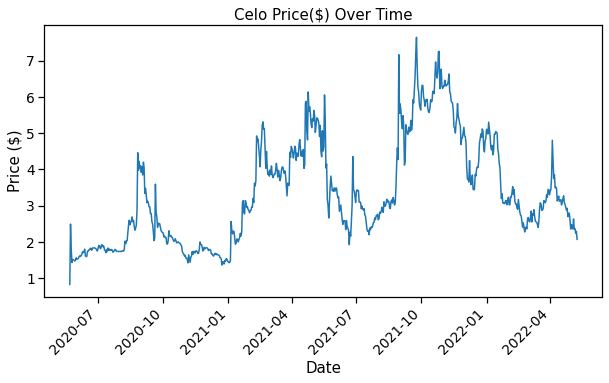

In [33]:
# line plot of crypto price over time
sns.set_context('notebook', font_scale = 1.25)
fig, ax = plt.subplots(figsize = (10, 5))
ax = sns.lineplot(x = df.index, y = df['Close'])
ax.set(title = 'Celo Price($) Over Time', ylabel = 'Price ($)')
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right')
plt.show()

As seen in the visualization above, we can see that Celo Closing Price (applies to all crypto price) is very volatile and could be any price on a given time.

## Visualize as Crypto Trading via Plotly

* Code for this visualization is taken from this [resource](https://pythoninoffice.com/draw-stock-chart-with-python/).

In [34]:
# adding a column indicator 
df['diff'] = df['Close'] - df['Open']
df.loc[df['diff'] >= 0, 'color'] = 'green'
df.loc[df['diff'] < 0, 'color'] = 'red'

In [36]:
# plot trading view via plotly
fig = make_subplots(specs=[[{"secondary_y": True}]])
# fig.add_trace(go.Scatter(x=df['Date'], y = df['Close'], name = 'Price'), secondary_y = False)
fig.add_trace(go.Candlestick(x = df.index, 
                             open = df['Open'], 
                             high = df['High'], 
                             low = df['Low'],
                             close = df['Close'],
                             name = 'Price'
                             ))
fig.add_trace(go.Scatter(x = df.index, 
                         y = df['Close'].rolling(window=20).mean(), 
                         marker_color = 'blue', 
                         name = '20 Day MA'
                        ))
fig.add_trace(go.Bar(x=df.index, 
                     y = df['Volume'], 
                     name = 'Volume',
                     marker = {'color' : df['color']}
                     ), 
              secondary_y = True
              )
fig.update_yaxes(range = [0, 7000000000], secondary_y = True)
fig.update_yaxes(visible=False, secondary_y = True)
fig.update_layout(title = {'text': 'Celo Trading View', 'x' : 0.5})
# uncomment the line below to disable the range slider
fig.update_layout(xaxis_rangeslider_visible = False)
# fig.show('png') -> will be used to show a static view of the graph in GitHub, 
# fig.show() without any attribute will be used to make interactive in Google Colab.
fig.show()

*The visual above is a trading view of the Celo Price (Low, High and Close) daily, and the Volume by day (with green and red indicators). This also includes a 20 Day Moving Average (blue) one indicator that help traders decide whether to buy or sell or hold their assets.*

In [11]:
# save the graph above to html 
# fig.write_html(r'/content/drive/MyDrive/CodingDojo_DS/dataset_files/graph.html')

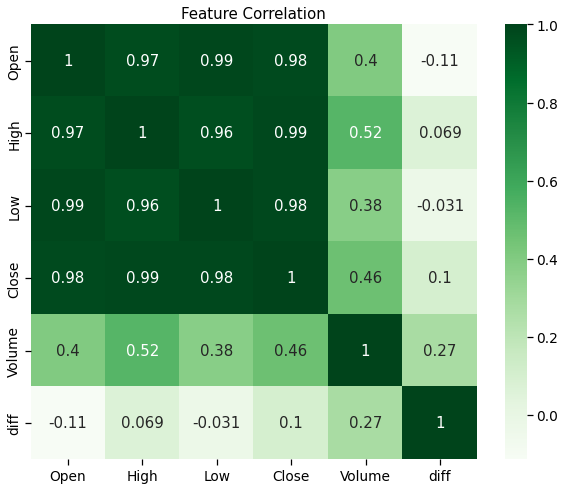

In [37]:
# heatmap plot of dimension correlation
corr = df.corr()
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(corr, cmap = 'Greens', annot = True)
ax.set(title = 'Feature Correlation')
plt.show()

Our data shows that prices (Open, Low, High and Closing) are greatly correlated and is also somewhat correlated to our Volume. 

## Applying Feature Engineering on Datetime

We will be adding the following dimensions from the datetime feature
- year
- month (name)
- day of month
- day of week (name)

In [38]:
# feature engineering for datetime dimension
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
# df['day of week (name)'] = df['Date'].dt.day_name()
df.head()

,Open,High,Low,Close,Volume,diff,color,year,month,day
Date,,,,,,,,,,
2020-05-22,0.82595,0.97836,0.79553,0.83266,2019357,0.00671,green,2020,5,22
2020-05-23,0.83277,2.51691,0.83277,2.49621,3645282,1.66343,green,2020,5,23
2020-05-24,2.43167,3.91659,1.47054,1.81345,3305900,-0.61823,red,2020,5,24
2020-05-25,1.80970,1.93593,1.42681,1.43638,2211306,-0.37332,red,2020,5,25
2020-05-26,1.43650,1.94548,1.42443,1.52262,2323976,0.08612,green,2020,5,26


## Machine Learning Model

Predict Close (Price) based on features. We will be testing our data with multiple Machine Learning Algorithms (Regression) and decide which Algorithm we will be using for production.

In [39]:
# set target and features
X = df.drop(columns = 'Close')
y = df['Close']
# model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [40]:
# scaler and ohe instance
scaler = MinMaxScaler()
ohe = OneHotEncoder(handle_unknown = 'ignore')
# make selectors
cat_selector = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')
# make preproce pipeline
cat_tuple = (ohe, cat_selector)
num_tuple = (scaler, num_selector)
preproc = make_column_transformer(cat_tuple, num_tuple)

**Testing with XGBRegressor Model**

Testing Data Metrics
r2_score: 0.9948142762603764
mae_score: 0.06462143460909522
mse_score: 0.011080051223118342
rmse_score: 0.10526182224870678




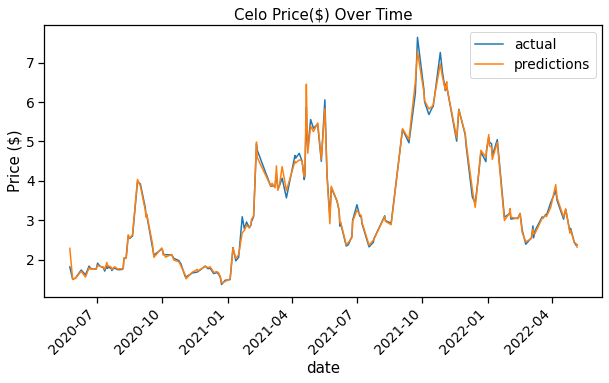

In [42]:
model = XGBRegressor(objective = 'reg:squarederror', random_state = 42)
build_n_eval_model(preproc, model, X_train, X_test, y_train, y_test)

**Testing using RandomForestRegressor**

Testing Data Metrics
r2_score: 0.9919476765132919
mae_score: 0.07109416227539384
mse_score: 0.017204957529095687
rmse_score: 0.13116766952681475




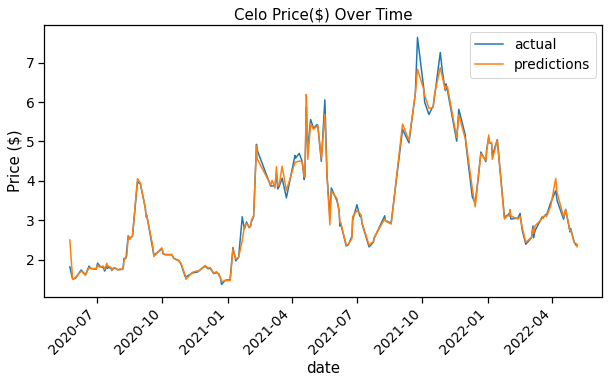

In [43]:
param_grid = {
    'max_depth' : [2, 30, 1],
    'n_estimators' : [50, 200, 25],
    'random_state' : [42]
}
rf = RandomForestRegressor()
clf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)
build_n_eval_model(preproc, clf, X_train, X_test, y_train, y_test)

**LSTM Nerual Network Model**

In [44]:
# this code block was grabed from the class notes link below : 
# https://colab.research.google.com/drive/19rXmqAs2G5m1DXknfuT_KV1hYFSAgOrZ
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

# visualize neural network
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

In [24]:
# this code block was grabed from the class notes link below : 
# https://colab.research.google.com/drive/19rXmqAs2G5m1DXknfuT_KV1hYFSAgOrZ
# You can use this function to see how your model improves over time
def plot_history(history, metric=None, format = True):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  if format:
    axes[0].ticklabel_format(useOffset = False, axis = 'y', style = 'plain')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    if format:
      axes[1].ticklabel_format(useOffset = False, axis = 'y', style = 'plain')
    axes[1].legend()

  plt.show()

In [45]:
# model performance evulation function
def evaluate_model(y_true, y_pred):
  """Takes true target and predicted target and prints MAE, MSE, RMSE and R2"""
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  # print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')
  return {"r2": r2, "mae": mae, "mse": mse, "rmse": rmse}

In [60]:
def build_nn_eval_model(X_train, X_test, y_train, y_test, name, n_layers=0, 
                       neurons=50, layer_activation='relu', output_activation='sigmoid', 
                       loss='bce', optimizer='adam', epochs = 20, metric_name = 'accuracy', 
                       is_vis_nn = True, format_plot = True, problem = 'reg', m_class = 3, is_dropout = False, drop_proba = 0.2,
                       is_early_stop = False, patience = 5):
  # sequential model
  model = Sequential(name = name)
  # frist layer
  model.add(Dense(neurons,
                  input_dim = X_train.shape[1],
                  activation = layer_activation,
                  name = 'input_layer'
                  ))
  if is_dropout:
    model.add(Dropout(drop_proba, name = 'input_dropout'))
  layer_name = 1
  while n_layers >= 1:
    model.add(Dense(neurons,
                    activation = layer_activation,
                    name = f'layer_{layer_name}'
                    ))
    if is_dropout:
      model.add(Dropout(drop_proba, name = f'layer_{layer_name}_dropout'))
    layer_name += 1
    n_layers -= 1
  # output layer
  if problem == 's_class':
    model.add(Dense(1, activation = output_activation, name = 'output_layer'))
  elif problem =='m_class':
    model.add(Dense(m_class, activation = output_activation, name = 'output_layer'))
  elif problem == 'reg':
    model.add(Dense(1, name = 'output_layer'))
  # compile
  model.compile(loss = loss, optimizer = optimizer, metrics = [metric_name])
  print('\n')
  # print model summary
  model.summary()
  if is_early_stop:
    early_stopping = EarlyStopping(patience = patience)
    hist = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, verbose = 0, callbacks = [early_stopping])
  # fit and get history
  else:
    hist = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, verbose = 0)
  print('\n')
  if is_vis_nn:
    visualize_nn(model, description=True, figsize=(13,10))
  # fit and get history
  hist = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, verbose = 0)
  preds = model.predict(X_test)
  score = model.evaluate(X_test, y_test, verbose=0)
  print('\n')
  # plot the test loss
  if format_plot:
    plot_history(hist, metric_name)
  else:
    plot_history(hist, metric_name, format = False)
  print('\n')
  # get preds and evaluate model
  if problem == 's_class':
    preds = np.rint(model.predict(X_test))
    print(classification_report(y_test, preds))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
  elif problem == 'm_class':
    preds = np.argmax(np.rint(model.predict(X_test)), axis = 1)
    print(classification_report(y_test, preds))
    ConfusionMatrixDisplay.from_predictions(y_test, preds)
  elif problem == 'reg':
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    print('Train Model Evaluation')
    for metric, value in evaluate_model(y_train, train_preds).items():
      print(f"\t{metric}_score: {round(value, 2)}")
    print('Test Model Evaluation')
    for metric, value in evaluate_model(y_test, test_preds).items():
      print(f"\t{metric}_score: {round(value, 2)}")
  return model

In [48]:
X_train_proc = preproc.fit_transform(X_train)
X_test_proc = preproc.transform(X_test)

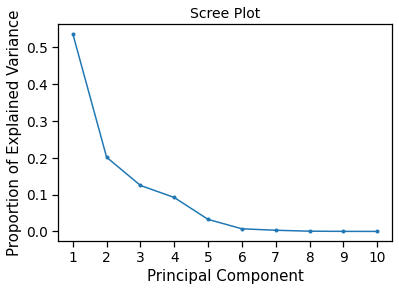

In [58]:
# pca instance
pca = PCA()
pca.fit(X_train_proc)

# scree plot
plt.plot(range(1, 11), pca.explained_variance_ratio_[:10], marker = '.')
plt.xticks(ticks = range(1, 11))
plt.title('Scree Plot', fontsize = 14)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Explained Variance');

In [52]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_proc)
X_test_pca = pca.transform(X_test_proc)



Model: "regression_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (Dense)         (None, 2000)              12000     
                                                                 
 input_dropout (Dropout)     (None, 2000)              0         
                                                                 
 layer_1 (Dense)             (None, 2000)              4002000   
                                                                 
 layer_1_dropout (Dropout)   (None, 2000)              0         
                                                                 
 output_layer (Dense)        (None, 1)                 2001      
                                                                 
Total params: 4,016,001
Trainable params: 4,016,001
Non-trainable params: 0
_________________________________________________________________






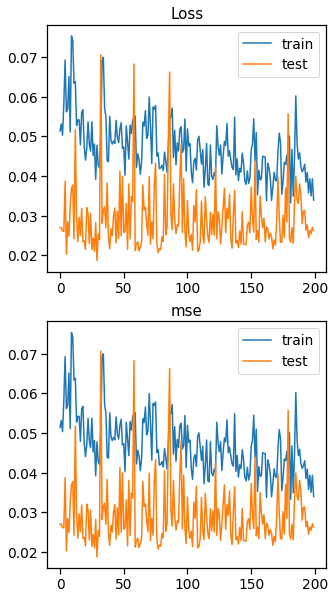



Train Model Evaluation
	r2_score: 0.99
	mae_score: 0.1
	mse_score: 0.02
	rmse_score: 0.15
Test Model Evaluation
	r2_score: 0.99
	mae_score: 0.11
	mse_score: 0.03
	rmse_score: 0.16


In [77]:
model = build_nn_eval_model(X_train_pca, 
                            X_test_pca, 
                            y_train, 
                            y_test, 
                            name = 'regression_model',
                            n_layers = 1,
                            neurons = 2000,
                            problem = 'reg',
                            loss = 'mse',
                            metric_name = 'mse',
                            is_vis_nn = False,
                            is_dropout = True,
                            drop_proba = 0.4,
                            epochs = 200
)

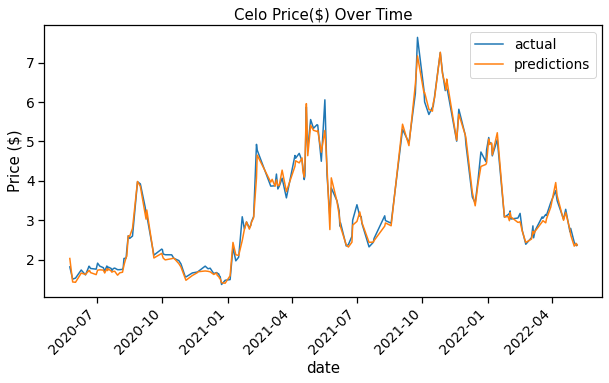

In [78]:
test_preds = model.predict(X_test_pca)
# combine preds and true values to your features
X_test['predictions'] = test_preds
X_test['actual'] = y_test
# bring back the date feature
X_test['date'] = pd.to_datetime(X_test[['month','day','year']])
# # visualize the actual and predictions
actual_preds_plot(X_test, 'date', 'actual', 'predictions')